In [1]:
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"
import sys
from utils.tools import load_obj, save_obj
sys.path.append(r"./ewtpy")
import pandas as pd
import numpy as np
import ewtpy
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [2]:
def iewt1d(ewt,mfb):
    real = all(np.isreal(ewt[0]))
    if real:
        rec = np.zeros(len(ewt[0]))
        for i in range(0,len(ewt)):
            rec += np.real(np.fft.ifft(np.fft.fft(ewt[i])*mfb[i]))
    else:
        rec = np.zeros(len(ewt[0]))*0j
        for i in range(0,len(ewt)):
            rec += np.fft.ifft(np.fft.fft(ewt[i])*mfb[i])
    return rec

## 加载数据

In [80]:
TARGET = "brent"
df = pd.read_csv(f"./data/oil/{TARGET}.csv", index_col=0, parse_dates=True)
if "value" in df.columns:
    df = df.rename(columns = {"value":"53ea38cpu"})

df = df[[TARGET]]
cols = [TARGET]
df.head()

,brent
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


## ewt

In [81]:
def ewt(df, N = 3, detect = "locmax", reg = 'none', lengthFilter = 0, sigmaFilter = 0, Fs = 1):
     #number of supports
     #detection mode: locmax, locmaxmin, locmaxminf
     #spectrum regularization - it is smoothed with an average (or gaussian) filter 
     #length or average or gaussian filter
     #sigma of gaussian filter
     #sampling frequency, in Hz (if unknown, set 1)
    ewt_dict, mfb_dict, boundaries_dict = {}, {}, {}
    for col in cols:
        ewt, mfb, boundaries = ewtpy.EWT1D(df[col], 
                                            N = N,
                                            log = 0,
                                            detect = detect, 
                                            completion = 0, 
                                            reg = reg, 
                                            lengthFilter = lengthFilter,
                                            sigmaFilter = sigmaFilter)
        df[[f"{col}{i}" for i in range(N)]] = ewt
        df[[f"{col}{i}_mfb" for i in range(N)]] = mfb
        ewt_dict[col]=ewt; mfb_dict[col]=mfb; boundaries_dict[col]=boundaries
    return df, ewt_dict, mfb_dict

In [82]:
# ETW分量数量
N = 3
df, ewt_dict, mfb_dict = ewt(df, N=N)

In [83]:
df

,brent,brent0,brent1,brent2,brent0_mfb,brent1_mfb,brent2_mfb
Date,,,,,,,
1987-05-20,18.63,45.460317,11.721300,-30.662523,1.000000,0.000000,0.000000e+00
1987-05-21,18.45,45.434059,11.652941,-32.341790,1.000000,0.000000,0.000000e+00
1987-05-22,18.55,45.407773,11.584280,-30.703048,1.000000,0.000000,0.000000e+00
1987-05-25,18.60,45.381459,11.515320,-31.880706,0.966114,0.258117,0.000000e+00
1987-05-26,18.63,45.355116,11.446062,-30.682554,0.257503,0.966277,0.000000e+00
...,...,...,...,...,...,...,...
2022-06-29,120.80,45.591176,12.058532,69.928467,0.000000,1.000000,6.595124e-08
2022-06-30,119.78,45.565062,11.991699,69.936340,0.257503,0.966277,0.000000e+00
2022-07-01,119.21,45.538919,11.924558,68.258321,0.966114,0.258117,0.000000e+00


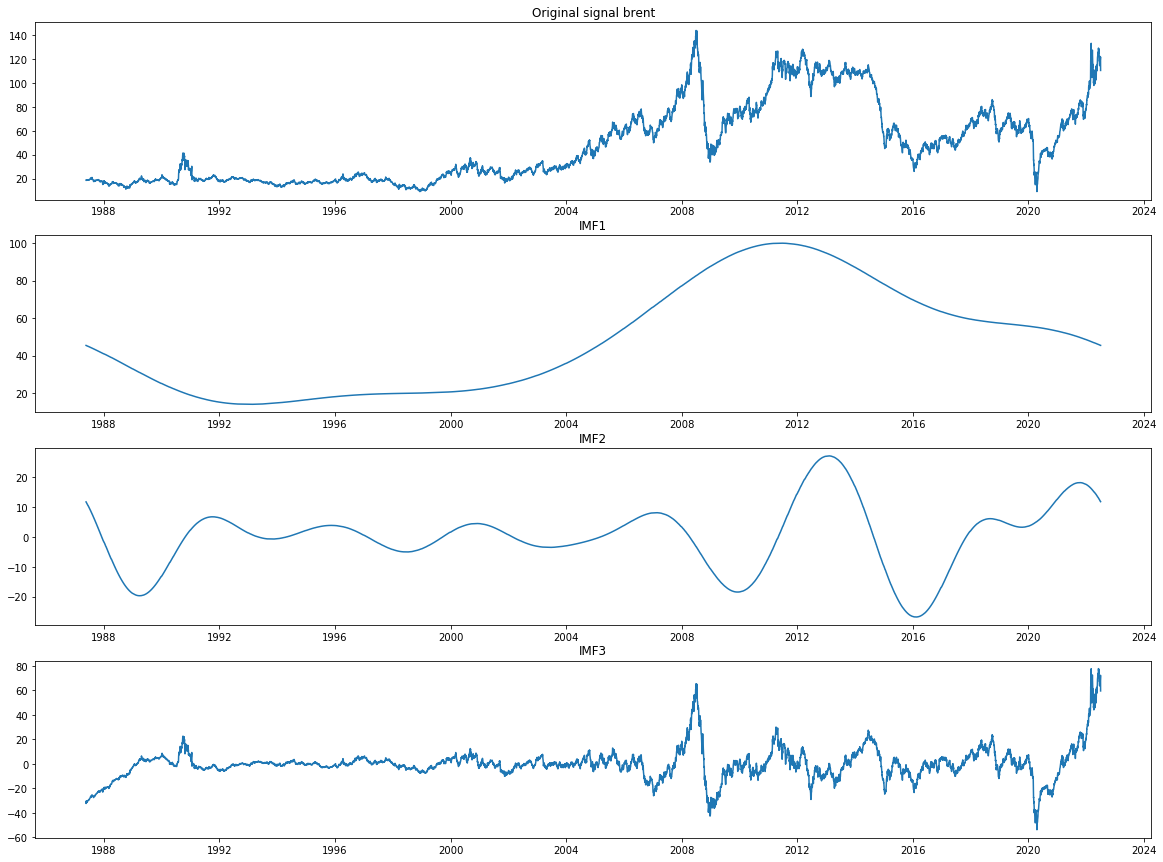

In [84]:
for col in cols:
    fig = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(df[col])
    _ = plt.title('Original signal %s'%col);
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(df[f"{col}{i}"])
        _ = plt.title(f'IMF{i+1}');

In [78]:
fig.savefig(f"./savefig/{TARGET}_0.png")

## iforest

In [54]:
# 模型训练
iforest = IsolationForest(n_estimators=100, max_samples='auto',  
                          contamination=0.05, max_features=1,  
                          bootstrap=False, n_jobs=-1, random_state=1)

In [55]:
# -1为异常，1为正常
iforest_dict = {}
for col in cols:
    for i in range(1, N):
        X = df[f"{col}{i}"].values.reshape(-1, 1)
        iforest = iforest.fit(X)
        iforest_dict[f"{col}{i}"] = iforest
        df[f"{col}{i}_label"] = iforest.predict(X) 

        # 预测 decision_function 可以得出 异常评分
        # df[f"{col}{i}_scores"] = iforest.decision_function(X) 

In [56]:
# import plotly.express as px
# for col in cols:
#     for i in range(1, N):
#         tmp_df = df.copy()
#         tmp_df[f'{col}{i}_anomaly'] = tmp_df[f'{col}{i}_label'].apply(lambda x: 'outlier' if x==-1  else 'inlier') 
#         fig = px.histogram(tmp_df,x=f"{col}{i}_scores",color=f'{col}{i}_anomaly')
#         fig.show()

## 插值

In [57]:
for col in cols:
    for i in range(1, N):
        df[f"{col}{i}"] = np.where(df[f"{col}{i}_label"]==1, df[f"{col}{i}"], np.nan)

In [58]:
df = df.interpolate(axis=0)
df = df.fillna(method="bfill")
df = df.drop(columns=df.columns[df.columns.str.contains("label")])

In [59]:
df

,wti,wti0,wti1,wti2,wti3,wti4,wti0_mfb,wti1_mfb,wti2_mfb,wti3_mfb,wti4_mfb
Date,,,,,,,,,,,
1986-01-02,25.56,40.983638,5.047781,9.753002,2.141840,-25.216900,1.0,0.0,0.0,0.0,0.0
1986-01-03,26.00,40.963412,5.010453,9.753002,2.077886,-25.216900,1.0,0.0,0.0,0.0,0.0
1986-01-06,26.53,40.943174,4.973054,9.753002,2.013833,-25.216900,1.0,0.0,0.0,0.0,0.0
1986-01-07,25.85,40.922924,4.935586,9.753002,1.949685,-25.216900,1.0,0.0,0.0,0.0,0.0
1986-01-08,25.87,40.902662,4.898047,9.753002,1.885444,-25.216900,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-28,113.66,41.084590,5.233353,10.801502,2.459994,19.802269,0.0,1.0,0.0,0.0,0.0
2022-06-29,111.65,41.064424,5.196383,10.801502,2.396590,19.802269,0.0,1.0,0.0,0.0,0.0
2022-06-30,107.76,41.044245,5.159340,10.801502,2.333069,19.802269,1.0,0.0,0.0,0.0,0.0


In [60]:
TARGET

'wti'

In [85]:
df.to_csv(f"./data/oil/{TARGET}.csv")